In [53]:
import sys
import json
import csv
import yaml
import os

# can use the following as alternative way to load a large
#    set of environment variables; see below
from dotenv import load_dotenv

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt


import time
from datetime import datetime

import pprint

import psycopg2
from sqlalchemy import create_engine, text as sql_text

In [54]:
# to add to the end of graph title
load_dotenv()

firstname = os.environ['firstname']
lastname = os.environ['lastname']
l4ID = os.environ['l4ID']

### 1. Listings Join Reviews Average Values per Year

In [55]:
# Load JSON data from the file
with open("listings_join_reviews.json", 'r') as file:
    data1 = json.load(file)
    json.dumps(data1, indent=4, sort_keys=True)

In [56]:
records1 = []
year_list = []

# create a list of all the keys in the JSON file
key_labels = {
    "__": "no index",
    "__datetime_in_reviews__": "index datetime in reviews",
      "__id_in_listings__": "index id in listings",
      "__datetime_in_reviews__id_in_listings__": "index datetime in reviews and id in listings"
}

for year_key, combos in data1.items():
    # year_key ex："listing_join_reviews_2009"
    year = year_key.replace("listing_join_reviews_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("avg", None)
    records1.append(row)

# construct DataFrame
df_avg1 = pd.DataFrame.from_records(records1)
df_avg1 = df_avg1.rename(columns=key_labels)
df_avg1 = df_avg1.set_index("year")
df_avg1 = df_avg1.astype(float)


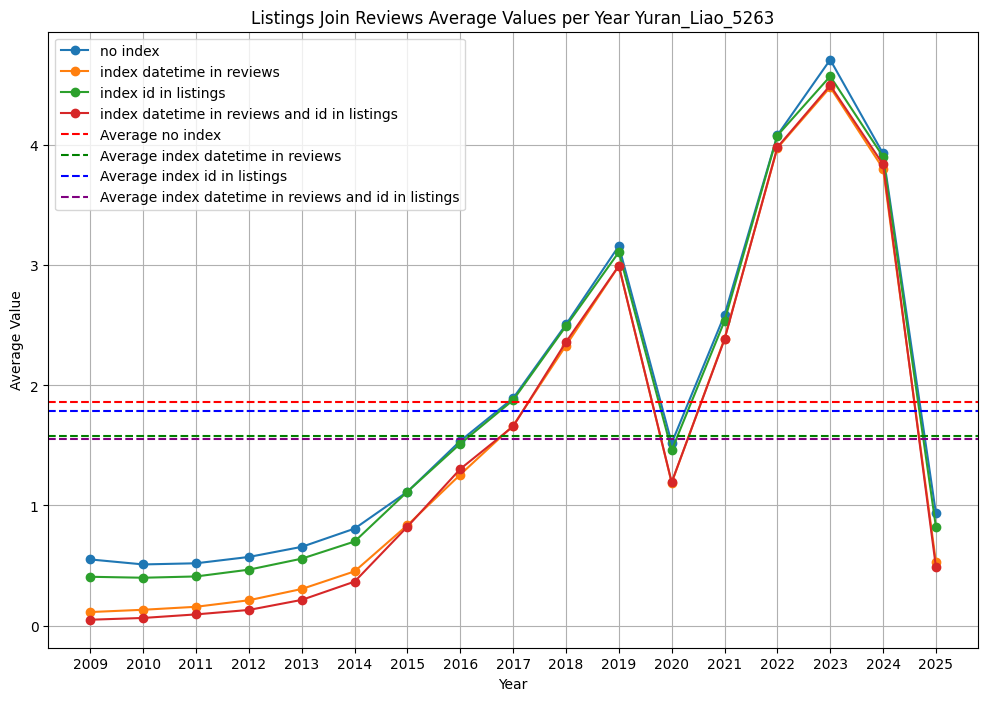

In [57]:
plt.figure(figsize=(12, 8))
for label in key_labels.values():
    plt.plot(df_avg1.index, df_avg1[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(key_labels.values()):
    avg_value = df_avg1[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Listings Join Reviews Average Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

### 2.Listings Join Reviews STD Values per Year

In [58]:
records2 = []

for year_key, combos in data1.items():
    # year_key ex："listing_join_reviews_2009"
    year = year_key.replace("listing_join_reviews_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("std", None)
    records2.append(row)

# construct DataFrame
df_std2 = pd.DataFrame.from_records(records2)
df_std2 = df_std2.rename(columns=key_labels)
df_std2 = df_std2.set_index("year")
df_std2 = df_std2.astype(float)

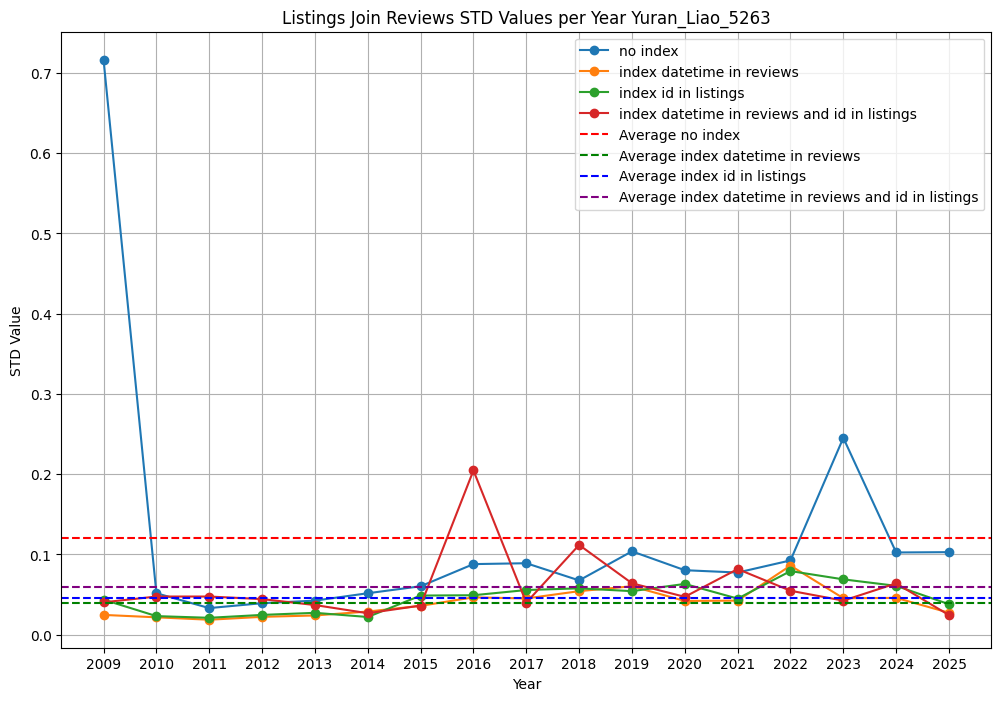

In [59]:
plt.figure(figsize=(12, 8))

for label in key_labels.values():
    plt.plot(df_std2.index, df_std2[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(key_labels.values()):
    avg_value = df_std2[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Listings Join Reviews STD Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('STD Value')
plt.legend()
plt.grid(True)
plt.show()

### 3. Text Search HORRIBLE Average Values per Year

In [60]:
# Load JSON data from the file
with open("text_search_query.json", 'r') as file:
    data2 = json.load(file)
    json.dumps(data2, indent=4, sort_keys=True)

In [61]:
records3 = []
year_list = []

# create a list of all the keys in the JSON file
key_labels = {
    "__": "no_index",
    "__comments_tsv_in_reviews__": "only_tsv_index",
    "__datetime_in_reviews__": "only_datetime_index",
    "__datetime_in_reviews__comments_tsv_in_reviews__": "datetime_and_tsv_index"
}

In [62]:
# only keep the keys that start with "horrible_"
for year_key, combos in data2.items():
    if not year_key.startswith("horrible_"):
        continue
    year = year_key.replace("horrible_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("avg", None)
    records3.append(row)

df_horrible_avg = pd.DataFrame.from_records(records3)
df_horrible_avg = df_horrible_avg.rename(columns=key_labels)
df_horrible_avg = df_horrible_avg.set_index("year")
df_horrible_avg = df_horrible_avg.astype(float)


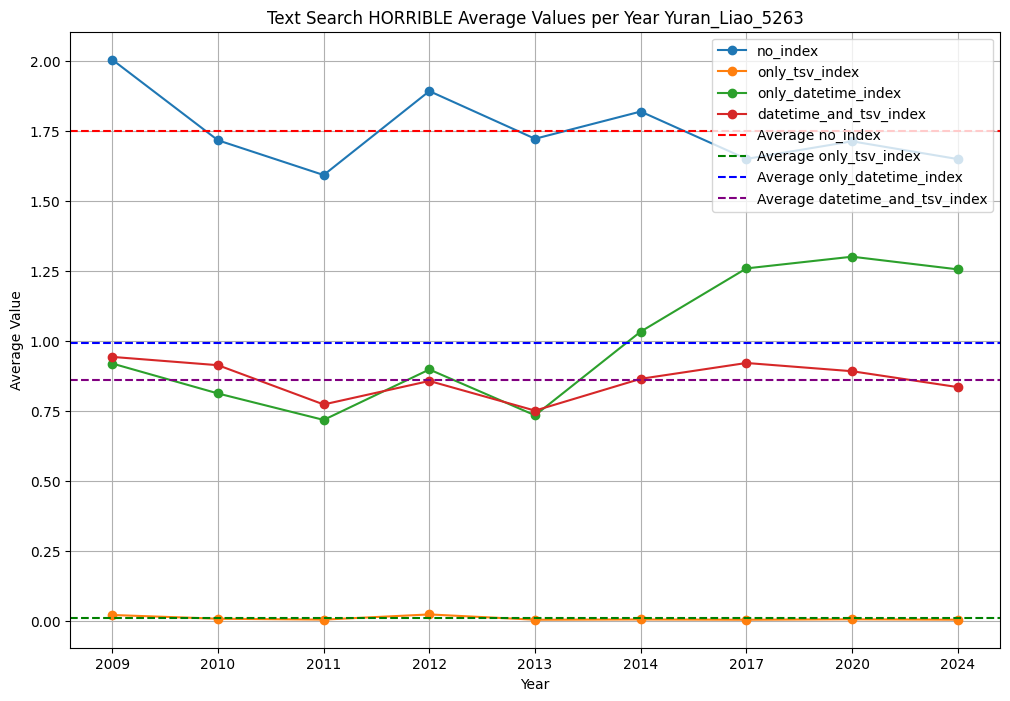

In [63]:
plt.figure(figsize=(12, 8))
for label in df_horrible_avg.columns:
    plt.plot(df_horrible_avg.index, df_horrible_avg[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(df_horrible_avg.columns):
    avg_value = df_horrible_avg[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Text Search HORRIBLE Average Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

### 4. Text Search HORRIBLE STD Values per Year

In [64]:
records4 = []
year_list = []

# only keep the keys that start with "horrible_"
for year_key, combos in data2.items():
    if not year_key.startswith("horrible_"):
        continue
    year = year_key.replace("horrible_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("std", None)
    records4.append(row)

df_horrible_std = pd.DataFrame.from_records(records4)
df_horrible_std = df_horrible_std.rename(columns=key_labels)
df_horrible_std = df_horrible_std.set_index("year")
df_horrible_std = df_horrible_std.astype(float)

print(df_horrible_std)

      no_index  only_tsv_index  only_datetime_index  datetime_and_tsv_index
year                                                                       
2009       0.0             0.0                  0.0                     0.0
2010       0.0             0.0                  0.0                     0.0
2011       0.0             0.0                  0.0                     0.0
2012       0.0             0.0                  0.0                     0.0
2013       0.0             0.0                  0.0                     0.0
2014       0.0             0.0                  0.0                     0.0
2017       0.0             0.0                  0.0                     0.0
2020       0.0             0.0                  0.0                     0.0
2024       0.0             0.0                  0.0                     0.0


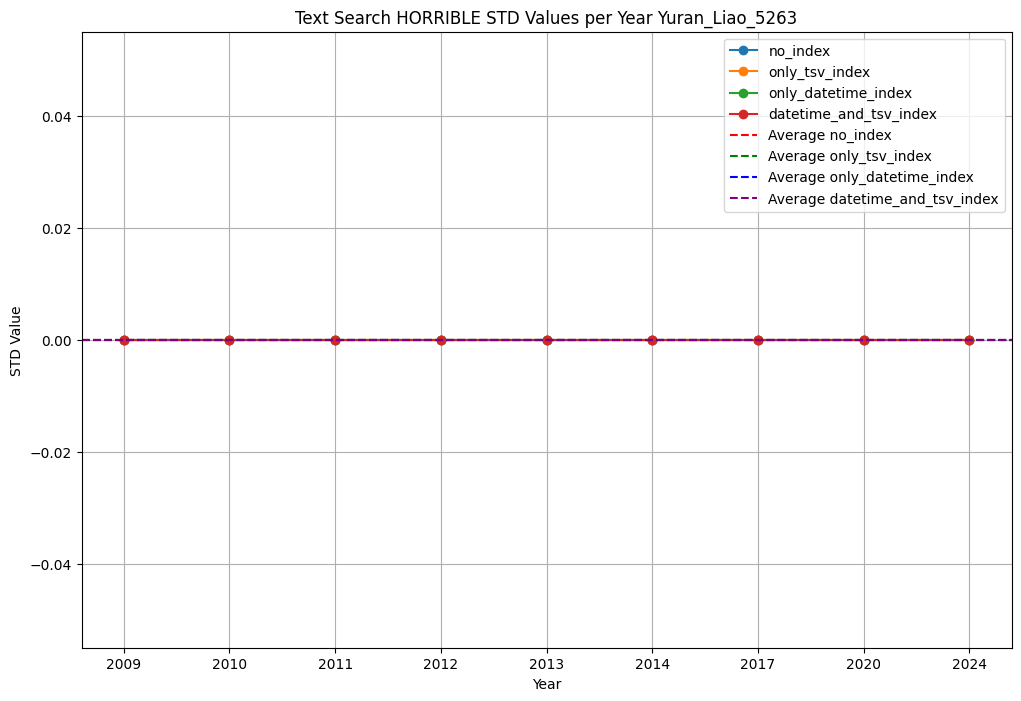

In [65]:
plt.figure(figsize=(12, 8))
for label in df_horrible_std.columns:
    plt.plot(df_horrible_std.index, df_horrible_std[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(df_horrible_std.columns):
    avg_value = df_horrible_std[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Text Search HORRIBLE STD Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('STD Value')
plt.legend()
plt.grid(True)
plt.show()

### 5. Text Search AWESOME Average Values per Year

In [66]:
records5 = []
year_list = []

# only keep the keys that start with "awesome_"
for year_key, combos in data2.items():
    if not year_key.startswith("awesome_"):
        continue
    year = year_key.replace("awesome_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("avg", None)
    records5.append(row)

df_awesome_avg = pd.DataFrame.from_records(records5)
df_awesome_avg = df_awesome_avg.rename(columns=key_labels)
df_awesome_avg = df_awesome_avg.set_index("year")
df_awesome_avg = df_awesome_avg.astype(float)

print(df_awesome_avg)

      no_index  only_tsv_index  only_datetime_index  datetime_and_tsv_index
year                                                                       
2009    1.9410          0.1169               0.8846                  0.9855
2010    1.7619          0.1518               0.9725                  0.8431
2011    1.6624          0.1274               0.9297                  0.8990
2012    1.7776          0.1231               0.9379                  0.9077
2013    1.8916          0.1477               0.9590                  0.9006
2014    1.7779          0.1046               1.0330                  0.8624
2017    1.6917          0.1098               1.3572                  0.7910
2020    1.7985          0.1152               1.1877                  0.9302
2024    1.9285          0.1428               1.4358                  0.9719


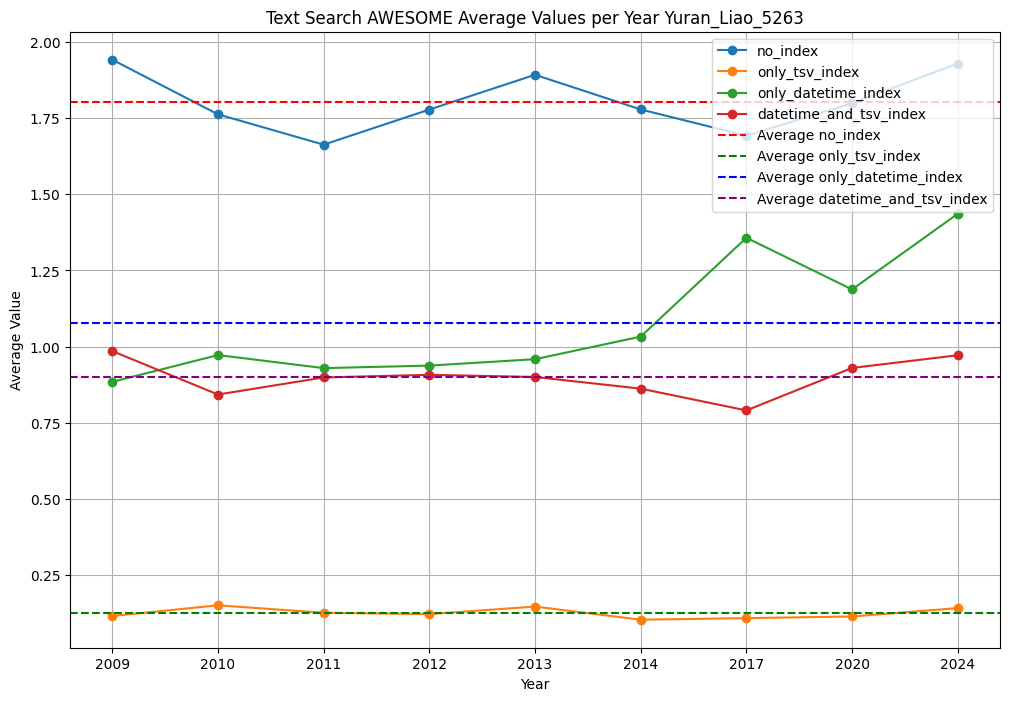

In [67]:
plt.figure(figsize=(12, 8))
for label in df_awesome_avg.columns:
    plt.plot(df_awesome_avg.index, df_awesome_avg[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(df_awesome_avg.columns):
    avg_value = df_awesome_avg[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Text Search AWESOME Average Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

### 6. Text Search AWESOME STD Values per Year

In [68]:
records6 = []
year_list = []

# only keep the keys that start with "awesome_"
for year_key, combos in data2.items():
    if not year_key.startswith("awesome_"):
        continue
    year = year_key.replace("awesome_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("std", None)
    records6.append(row)

df_awesome_std = pd.DataFrame.from_records(records6)
df_awesome_std = df_awesome_std.rename(columns=key_labels)
df_awesome_std = df_awesome_std.set_index("year")
df_awesome_std = df_awesome_std.astype(float)

print(df_awesome_std)

      no_index  only_tsv_index  only_datetime_index  datetime_and_tsv_index
year                                                                       
2009       0.0             0.0                  0.0                     0.0
2010       0.0             0.0                  0.0                     0.0
2011       0.0             0.0                  0.0                     0.0
2012       0.0             0.0                  0.0                     0.0
2013       0.0             0.0                  0.0                     0.0
2014       0.0             0.0                  0.0                     0.0
2017       0.0             0.0                  0.0                     0.0
2020       0.0             0.0                  0.0                     0.0
2024       0.0             0.0                  0.0                     0.0


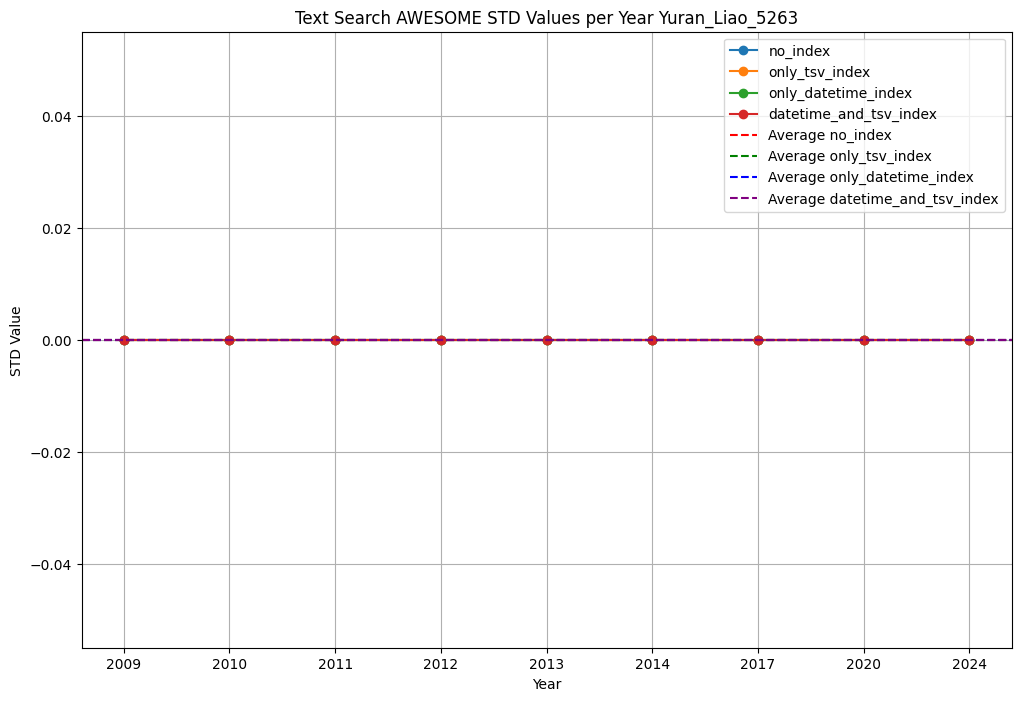

In [69]:
plt.figure(figsize=(12, 8))
for label in df_awesome_std.columns:
    plt.plot(df_awesome_std.index, df_awesome_std[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(df_awesome_std.columns):
    avg_value = df_awesome_std[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Text Search AWESOME STD Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('STD Value')
plt.legend()
plt.grid(True)
plt.show()

### 7. Text Search APARTMENT Average Values per Year

In [70]:
records7 = []
year_list = []

# only keep the keys that start with "apartment_"
for year_key, combos in data2.items():
    if not year_key.startswith("apartment_"):
        continue
    year = year_key.replace("apartment_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("avg", None)
    records7.append(row)

df_apartment_avg = pd.DataFrame.from_records(records7)
df_apartment_avg = df_apartment_avg.rename(columns=key_labels)
df_apartment_avg = df_apartment_avg.set_index("year")
df_apartment_avg = df_apartment_avg.astype(float)

print(df_apartment_avg)

      no_index  only_tsv_index  only_datetime_index  datetime_and_tsv_index
year                                                                       
2009    1.9093          0.8081               0.9702                  0.8488
2010    1.8147          0.5187               0.9104                  0.8100
2011    1.7389          0.5055               0.8730                  0.7658
2012    1.7961          0.5598               1.0699                  0.8717
2013    1.8128          0.5630               0.9984                  0.8519
2014    1.7144          0.5532               1.1096                  1.0342
2017    1.7166          0.5325               1.4234                  1.0196
2020    1.7863          0.5523               1.1488                  0.9760
2024    1.7833          0.5685               1.3713                  1.1876


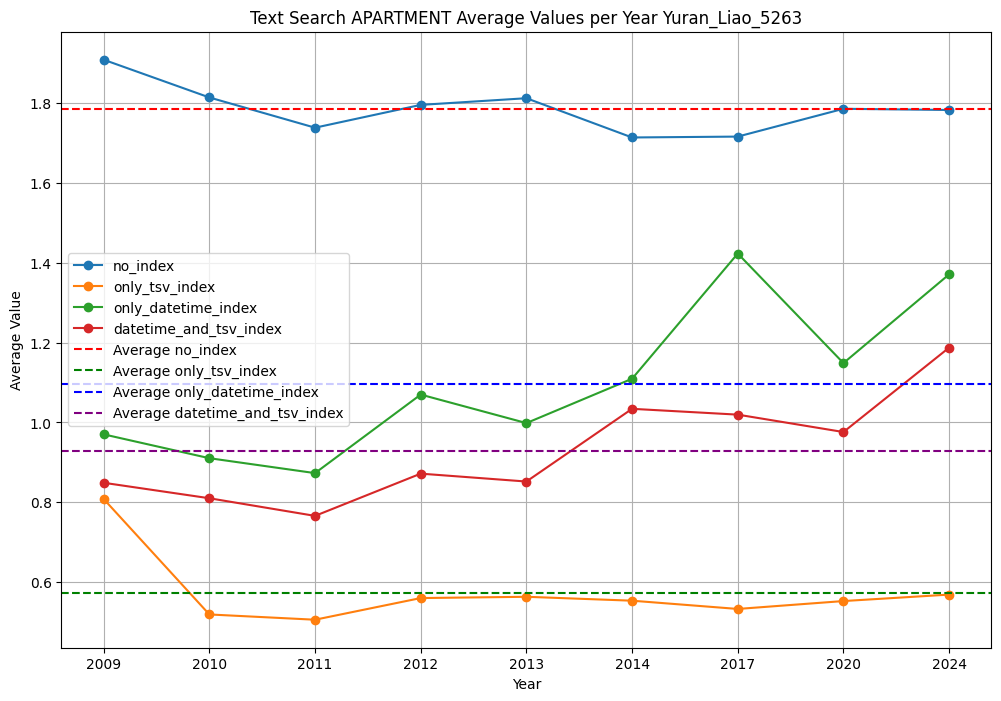

In [71]:
plt.figure(figsize=(12, 8))
for label in df_apartment_avg.columns:
    plt.plot(df_apartment_avg.index, df_apartment_avg[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(df_apartment_avg.columns):
    avg_value = df_apartment_avg[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Text Search APARTMENT Average Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

### 8. Text Search APARTMENT STD Values per Year

In [72]:
records8 = []
year_list = []

# only keep the keys that start with "apartment_"
for year_key, combos in data2.items():
    if not year_key.startswith("apartment_"):
        continue
    year = year_key.replace("apartment_", "")
    year_list.append(year)
    row = {"year": year}
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("std", None)
    records8.append(row)

df_apartment_std = pd.DataFrame.from_records(records8)
df_apartment_std = df_apartment_std.rename(columns=key_labels)
df_apartment_std = df_apartment_std.set_index("year")
df_apartment_std = df_apartment_std.astype(float)

print(df_apartment_std)

      no_index  only_tsv_index  only_datetime_index  datetime_and_tsv_index
year                                                                       
2009       0.0             0.0                  0.0                     0.0
2010       0.0             0.0                  0.0                     0.0
2011       0.0             0.0                  0.0                     0.0
2012       0.0             0.0                  0.0                     0.0
2013       0.0             0.0                  0.0                     0.0
2014       0.0             0.0                  0.0                     0.0
2017       0.0             0.0                  0.0                     0.0
2020       0.0             0.0                  0.0                     0.0
2024       0.0             0.0                  0.0                     0.0


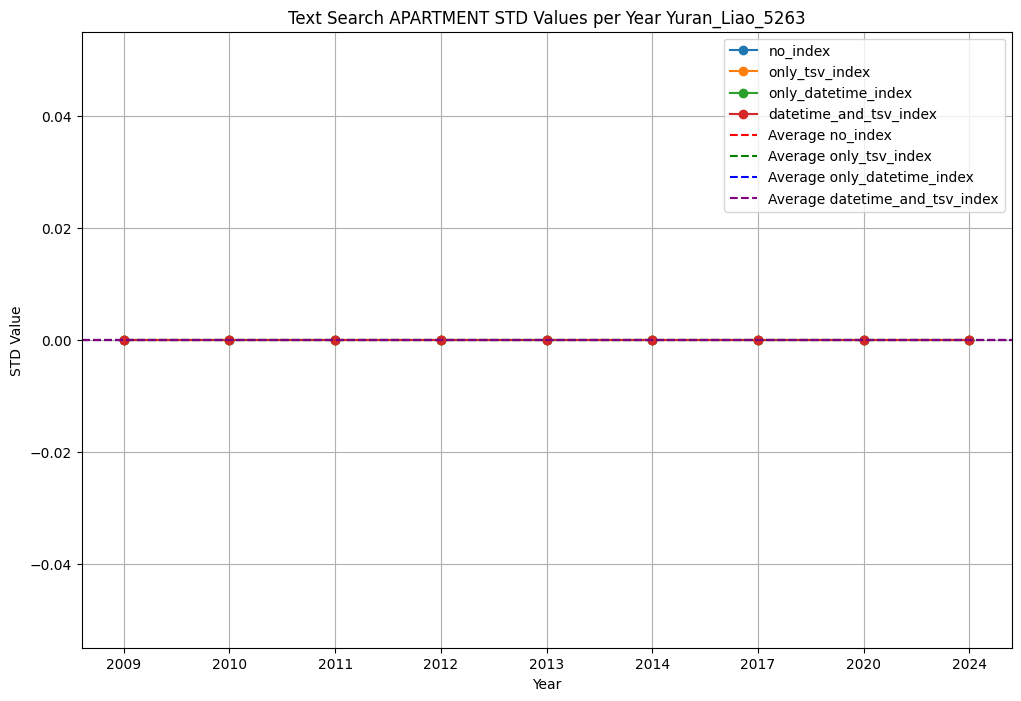

In [73]:
plt.figure(figsize=(12, 8))
for label in df_apartment_std.columns:
    plt.plot(df_apartment_std.index, df_apartment_std[label], marker='o', label=label)

colors = ['red', 'green', 'blue', 'purple']
for idx, label in enumerate(df_apartment_std.columns):
    avg_value = df_apartment_std[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')

plt.title(f'Text Search APARTMENT STD Values per Year {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('STD Value')
plt.legend()
plt.grid(True)
plt.show()

### 9. Update Datetimes Query Average Values per Location

In [74]:
# Load JSON data from the file
with open("update_datetimes_query.json", 'r') as file:
    data = json.load(file)
    json.dumps(data, indent=4, sort_keys=True)

In [75]:
records = []
location_list = []

# create a list of all the keys in the JSON file
key_labels = {
    "__": "no_index",
    "__datetime_in_reviews__": "datetime_index",
    "__neigh_in_listings__": "neighbourhood_index",
    "__datetime_in_reviews__neigh_in_listings__": "datetime_and_neighbourhood_index"
}

for loc_key, combos in data.items():
    # loc_key, ex. "update_datetimes_query_Bedford-Stuyvesant"
    location = loc_key.replace("update_datetimes_query_", "")

    # record the location in order
    location_list.append(location)
    row = {"location": location}
    
    # interate through combo_tag（"__", "__datetime_in_reviews__", …）
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("avg", None)
    records.append(row)

# construct DataFrame
loc_std = pd.DataFrame.from_records(records)

# rename columns by using the key_labels dictionary
loc_avg = loc_std.rename(columns=key_labels)

# set location as index
loc_avg = loc_avg.set_index("location")

print(loc_avg)

                    no_index  datetime_index  neighbourhood_index  \
location                                                            
New Springville       0.8909          0.9605               0.8571   
Fort Hamilton         0.9033          1.1005               0.9347   
Long Island City      0.9728          1.7497               0.9840   
Bedford-Stuyvesant    2.0756          8.0692               1.8544   
Staten Island         1.0765          2.0580               0.9684   
Bronx                 1.3593          2.9052               1.3082   
Queens                5.9937         13.4938               7.1808   
Manhattan            11.2363         26.1012              12.1307   

                    datetime_and_neighbourhood_index  
location                                              
New Springville                               0.8525  
Fort Hamilton                                 1.0327  
Long Island City                              1.7590  
Bedford-Stuyvesant                

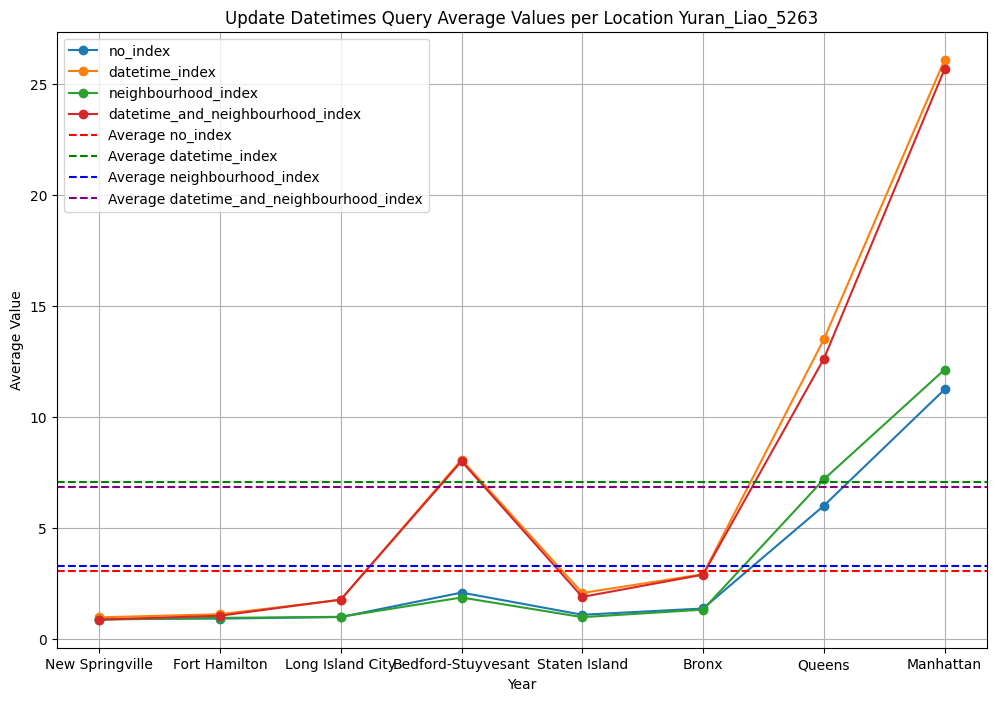

In [76]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(loc_avg.index, loc_avg[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot average lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    avg_value = loc_avg[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')


plt.title(f'Update Datetimes Query Average Values per Location {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()

### 10. Update Datetimes Query STD Values per Location

In [77]:
record_std = []

for loc_key, combos in data.items():
    # loc_key, ex. "update_datetimes_query_Bedford-Stuyvesant"
    location = loc_key.replace("update_datetimes_query_", "")

    # record the location in order
    location_list.append(location)
    row = {"location": location}
    
    # interate through combo_tag（"__", "__datetime_in_reviews__", …）
    for combo_tag, stats in combos.items():
        row[combo_tag] = stats.get("std", None)
    record_std.append(row)

# construct DataFrame
loc_std = pd.DataFrame.from_records(record_std)

# rename columns by using the key_labels dictionary
loc_std = loc_std.rename(columns=key_labels)

# set location as index
loc_std = loc_std.set_index("location")

print(loc_std)


                    no_index  datetime_index  neighbourhood_index  \
location                                                            
New Springville       0.2583          0.1077               0.0746   
Fort Hamilton         0.1265          0.1402               0.0964   
Long Island City      0.1528          0.3745               0.1814   
Bedford-Stuyvesant    0.7097          2.7872               0.3409   
Staten Island         0.1965          0.4000               0.1325   
Bronx                 0.1763          0.3106               0.1090   
Queens                3.3286          4.7061               6.0428   
Manhattan             8.4047          5.7612               9.3311   

                    datetime_and_neighbourhood_index  
location                                              
New Springville                               0.1067  
Fort Hamilton                                 0.1493  
Long Island City                              0.3475  
Bedford-Stuyvesant                

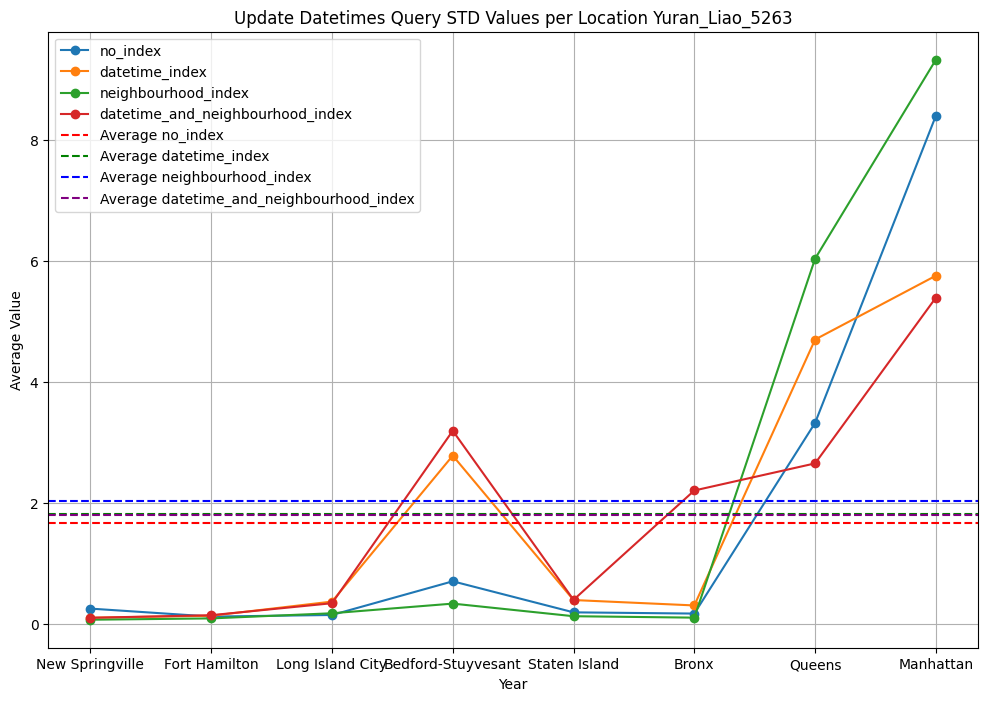

In [78]:
# Plotting the data
plt.figure(figsize=(12, 8))

# Plot each category data
for label in key_labels.values():
    plt.plot(loc_std.index, loc_std[label], marker='o', label=label)
    
colors = ['red', 'green', 'blue', 'purple']

# Calculate and plot average lines for each index across all years
for idx, label in enumerate(key_labels.values()):
    avg_value = loc_std[label].mean()
    plt.axhline(y=avg_value, linestyle='--', color=colors[idx], label=f'Average {label}')


plt.title(f'Update Datetimes Query STD Values per Location {firstname}_{lastname}_{l4ID}')
plt.xlabel('Year')
plt.ylabel('Average Value')
plt.legend()
plt.grid(True)
plt.show()